<a href="https://colab.research.google.com/github/Elshraby/GradProj4/blob/main/17_NEW_MoreEpochs_Prob_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# 📦 Install & Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [24]:
def assign_configuration_ids(df, feature_columns):
    config_values = df[feature_columns].astype(str).agg('-'.join, axis=1)
    df['config_id'] = pd.factorize(config_values)[0]
    return df

def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Features to define configuration (excluding TSR)
    config_features = ['Airfoil', 'Number of Blades', 'Cord Length', 'Height',
                       'Diameter', 'Pitch Angle', 'Freestream Velocity']
    df = assign_configuration_ids(df, config_features)

    target_col = 'Power Coefficient'
    tsr_col = 'Tip Speed Ratio'

    X_config = df[config_features]
    X_tsr = df[[tsr_col]]
    y = df[[target_col]].values

    categorical_cols = X_config.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = [col for col in X_config.columns if col not in categorical_cols]

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ])

    X_train_cfg, X_test_cfg, X_train_tsr, X_test_tsr, y_train, y_test = train_test_split(
        X_config, X_tsr, y, test_size=0.2, random_state=42
    )

    X_train_cfg_proc = preprocessor.fit_transform(X_train_cfg)
    X_test_cfg_proc = preprocessor.transform(X_test_cfg)

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    return (X_train_cfg_proc, X_test_cfg_proc, X_train_tsr.values, X_test_tsr.values,
            y_train_scaled, y_test_scaled, preprocessor, y_scaler)

In [25]:
class TSRConditionalModel(nn.Module):
    def __init__(self, config_input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(config_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.predictor = nn.Sequential(
            nn.Linear(32 + 1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, config_x, tsr_x):
        config_feat = self.encoder(config_x)
        combined = torch.cat([config_feat, tsr_x], dim=1)
        return self.predictor(combined)

In [26]:
def train_model(model, config_x, tsr_x, y, epochs=300, batch_size=32, lr=0.001):
    dataset = TensorDataset(torch.FloatTensor(config_x),
                            torch.FloatTensor(tsr_x),
                            torch.FloatTensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for config_batch, tsr_batch, y_batch in loader:
            optimizer.zero_grad()
            tsr_batch = tsr_batch.view(-1, 1)
            preds = model(config_batch, tsr_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 20 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss / len(loader):.5f}")

def evaluate_model(model, X_cfg, X_tsr, y_true, y_scaler):
    model.eval()
    with torch.no_grad():
        preds = model(torch.FloatTensor(X_cfg), torch.FloatTensor(X_tsr))
        preds_unscaled = y_scaler.inverse_transform(preds.numpy())
        y_true_unscaled = y_scaler.inverse_transform(y_true)
        r2 = r2_score(y_true_unscaled, preds_unscaled)
        mse = mean_squared_error(y_true_unscaled, preds_unscaled)
        print(f"R² Score: {r2:.4f}, MSE: {mse:.6f}")
        return y_true_unscaled, preds_unscaled

def plot_predictions(y_true, y_pred, target_name='Power Coefficient'):
    plt.figure(figsize=(6,4))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel(f"True {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Prediction for {target_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
def predict_cp(model, new_config_df, new_tsr_array, preprocessor, y_scaler):
    config_processed = preprocessor.transform(new_config_df)
    with torch.no_grad():
        preds = model(torch.FloatTensor(config_processed), torch.FloatTensor(new_tsr_array))
        return y_scaler.inverse_transform(preds.numpy())

Epoch 0/5000, Loss: 0.88574
Epoch 20/5000, Loss: 0.29336
Epoch 40/5000, Loss: 0.17687
Epoch 60/5000, Loss: 0.13507
Epoch 80/5000, Loss: 0.10810
Epoch 100/5000, Loss: 0.09364
Epoch 120/5000, Loss: 0.08705
Epoch 140/5000, Loss: 0.08083
Epoch 160/5000, Loss: 0.07483
Epoch 180/5000, Loss: 0.06899
Epoch 200/5000, Loss: 0.06590
Epoch 220/5000, Loss: 0.05928
Epoch 240/5000, Loss: 0.05945
Epoch 260/5000, Loss: 0.05823
Epoch 280/5000, Loss: 0.05359
Epoch 300/5000, Loss: 0.05327
Epoch 320/5000, Loss: 0.04729
Epoch 340/5000, Loss: 0.04521
Epoch 360/5000, Loss: 0.04409
Epoch 380/5000, Loss: 0.04719
Epoch 400/5000, Loss: 0.04131
Epoch 420/5000, Loss: 0.04175
Epoch 440/5000, Loss: 0.03979
Epoch 460/5000, Loss: 0.03899
Epoch 480/5000, Loss: 0.03957
Epoch 500/5000, Loss: 0.03727
Epoch 520/5000, Loss: 0.03725
Epoch 540/5000, Loss: 0.03452
Epoch 560/5000, Loss: 0.03717
Epoch 580/5000, Loss: 0.03449
Epoch 600/5000, Loss: 0.03284
Epoch 620/5000, Loss: 0.03498
Epoch 640/5000, Loss: 0.03336
Epoch 660/5000, 

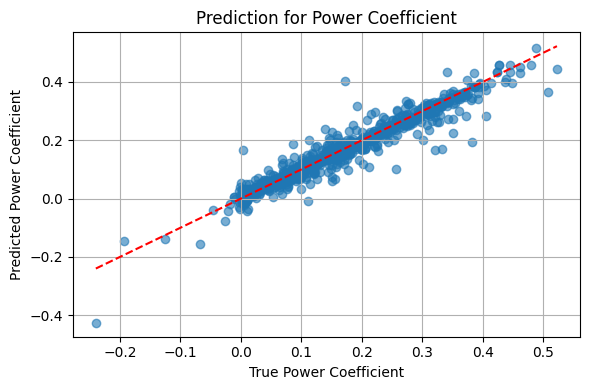

In [28]:
# Load and preprocess
X_train_cfg, X_test_cfg, X_train_tsr, X_test_tsr, y_train, y_test, preprocessor, y_scaler = load_and_preprocess_data('/content/Data.csv')

input_dim = X_train_cfg.shape[1]
model = TSRConditionalModel(config_input_dim=input_dim)

# Train
train_model(model, X_train_cfg, X_train_tsr, y_train, epochs=5000)

# Evaluate
y_true, y_pred = evaluate_model(model, X_test_cfg, X_test_tsr, y_test, y_scaler)
plot_predictions(y_true, y_pred)

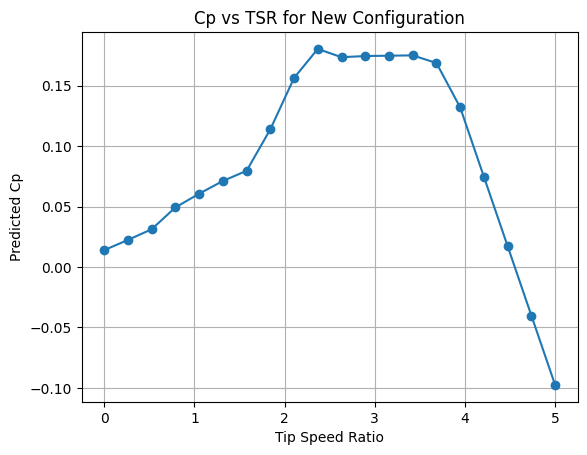

In [32]:
# 🔮 Predict Cp for a new configuration
example_df = pd.DataFrame([{
    'Airfoil': 'NACA0015',
    'Number of Blades': 3,
    'Cord Length': 0.3,
    'Height': 2.0,
    'Diameter': 4.0,
    'Pitch Angle': 0.0,
    'Freestream Velocity': 8.0
}])

# Predict for a range of TSR values
example_tsr = np.linspace(0, 5, 20).reshape(-1, 1)
predicted_cp = predict_cp(model, example_df.loc[example_df.index.repeat(20)].reset_index(drop=True),
                          example_tsr, preprocessor, y_scaler)

plt.plot(example_tsr.flatten(), predicted_cp.flatten(), 'o-')
plt.xlabel("Tip Speed Ratio")
plt.ylabel("Predicted Cp")
plt.title("Cp vs TSR for New Configuration")
plt.grid(True)
plt.show()

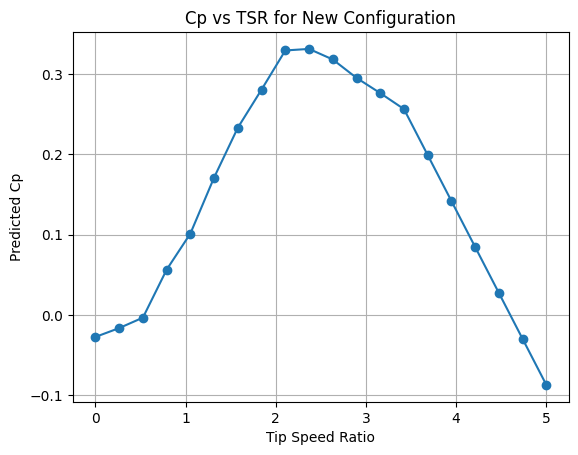

In [34]:
# 🔮 Predict Cp for a new configuration
example_df = pd.DataFrame([{
    'Airfoil': 'NACA0018',
    'Number of Blades': 3,
    'Cord Length': 0.3,
    'Height': 2.0,
    'Diameter': 4.0,
    'Pitch Angle': 0.0,
    'Freestream Velocity': 8.0
}])

# Predict for a range of TSR values
example_tsr = np.linspace(0, 5, 20).reshape(-1, 1)
predicted_cp = predict_cp(model, example_df.loc[example_df.index.repeat(20)].reset_index(drop=True),
                          example_tsr, preprocessor, y_scaler)

plt.plot(example_tsr.flatten(), predicted_cp.flatten(), 'o-')
plt.xlabel("Tip Speed Ratio")
plt.ylabel("Predicted Cp")
plt.title("Cp vs TSR for New Configuration")
plt.grid(True)
plt.show()